In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aslanahmedov_market_basket_analysis_path = kagglehub.dataset_download('aslanahmedov/market-basket-analysis')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/market-basket-analysis/Assignment-1_Data.xlsx
/kaggle/input/market-basket-analysis/Assignment-1_Data.csv


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/market-basket-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/market-basket-analysis


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # Importing make_subplots

from mlxtend.frequent_patterns import apriori,association_rules


import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/kaggle/input/market-basket-analysis/Assignment-1_Data.csv",sep=";")

In [ ]:
data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


# # Step | Overview and Data Cleaning

In [ ]:
print("#" * 50)
print(" " * 15, "Dataset Information")
print("#" * 50)
print("The Dataset has {} columns and {} rows.".format(data.shape[1], data.shape[0]))
print("The DataFrame has {} duplicated values and {} missing values.".format(data.duplicated().sum(), data.isnull().sum().sum()))
print(data.info())

##################################################
                Dataset Information
##################################################
The Dataset has 7 columns and 522064 rows.
The DataFrame has 5284 duplicated values and 135496 missing values.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB
None


#  # | Data Cleaning (Ensuring Consistency)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.isnull().sum()

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    133967
Country            0
dtype: int64

In [ ]:
#Dropping rows where ItemName isn't available
data.dropna(subset=["Itemname"],inplace=True)
#Dropping rows where Quantity <=0
df = data[data["Quantity"]>0]
df.isnull().sum()

BillNo             0
Itemname           0
Quantity           0
Date               0
Price              0
CustomerID    132039
Country            0
dtype: int64

In [ ]:
#Fill missing customer IDs
df['CustomerID'].fillna(99999, inplace=True)
#Create SumPrice column
df["SumPrice"]=df["Quantity"]*df["Price"]

In [ ]:
df.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
Country       0
SumPrice      0
dtype: int64

In [ ]:
df["Itemname"] = df["Itemname"].str.strip()

In [ ]:
df["BillNo"] = df["BillNo"].astype(str)

In [ ]:
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y %H:%M")

In [ ]:
df["Price"] = df["Price"].str.replace(",",".")

In [ ]:
df["CustomerID"] = df["CustomerID"].astype(str).str.replace(".0","")

In [ ]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,SumPrice
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,"2,552,552,552,552,552,55"
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,"3,393,393,393,393,393,39"
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,"2,752,752,752,752,752,752,752,75"
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,"3,393,393,393,393,393,39"
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,"3,393,393,393,393,393,39"


In [ ]:
#Find the best selling items in each country
best_selling_items = df.groupby(['Country', 'Itemname']).agg({'Quantity': 'sum'}).reset_index()
best_selling_items = best_selling_items.groupby('Country').apply(lambda x: x[x['Quantity'] == x['Quantity'].max()]).reset_index(drop=True)
best_selling_items.sort_values("Quantity",ascending=False)

,Country,Itemname,Quantity
47,United Kingdom,"PAPER CRAFT , LITTLE BIRDIE",80995
25,Netherlands,RABBIT NIGHT LIGHT,4801
12,France,RABBIT NIGHT LIGHT,4024
20,Japan,RABBIT NIGHT LIGHT,3408
0,Australia,MINI PAINT SET VINTAGE,2952
42,Sweden,MINI PAINT SET VINTAGE,2916
13,Germany,ROUND SNACK BOXES SET OF4 WOODLAND,1221
41,Spain,CHILDRENS CUTLERY POLKADOT PINK,729
43,Switzerland,PLASTERS IN TIN WOODLAND ANIMALS,639
26,Norway,SMALL FOLDING SCISSOR(POINTED EDGE),576


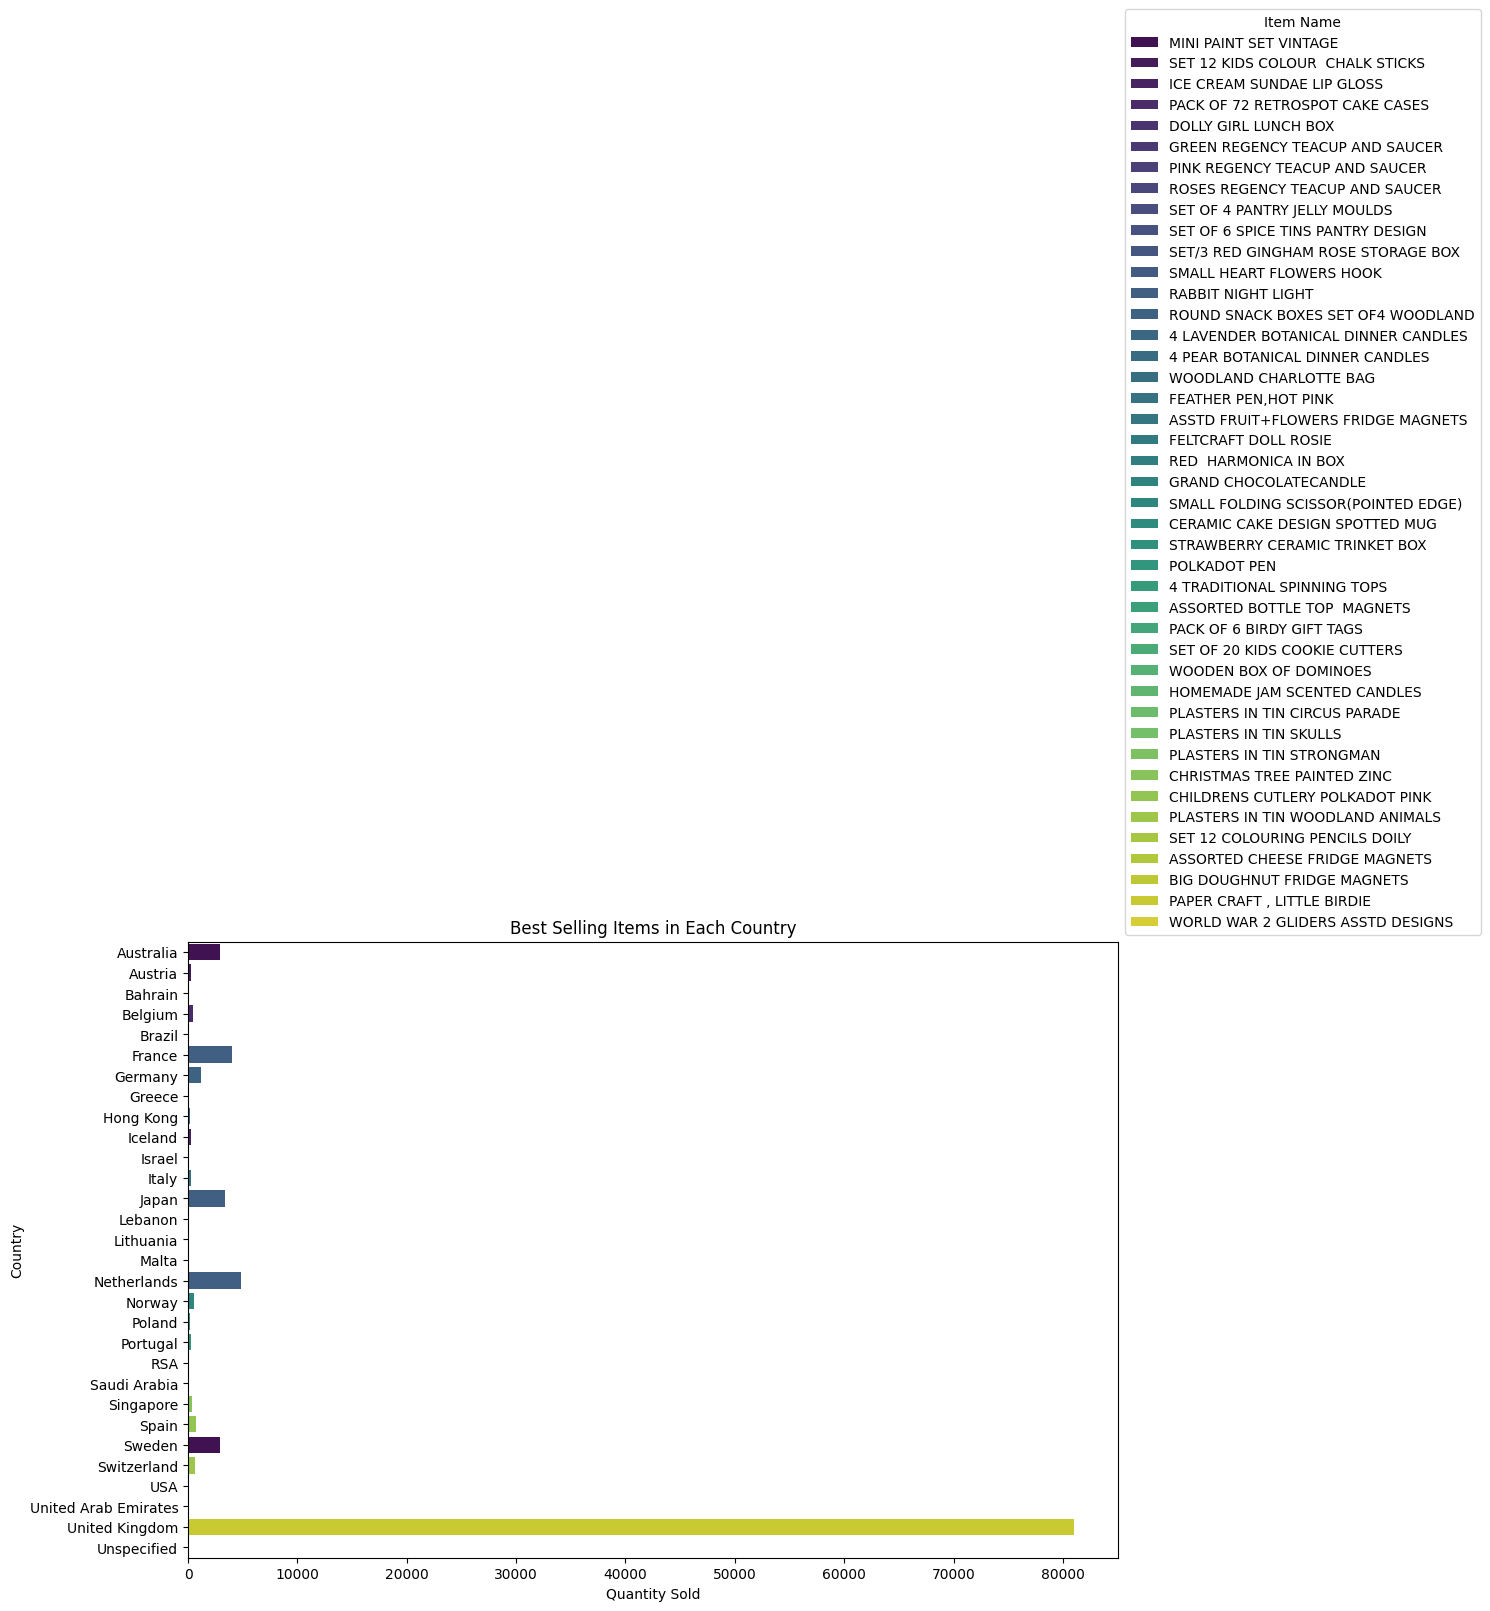

In [ ]:
# إعداد الرسم البياني
plt.figure(figsize=(12, 8))
sns.barplot(data=best_selling_items, x='Quantity', y='Country', hue='Itemname', dodge=False, palette="viridis")

# تخصيص الرسم
plt.title('Best Selling Items in Each Country')
plt.xlabel('Quantity Sold')
plt.ylabel('Country')
plt.legend(title="Item Name", bbox_to_anchor=(1, 1))

# عرض الرسم
plt.tight_layout()
plt.show()

In [ ]:
#Isolate the UK data and let's sort the most popular items in UK by quantity sold.
only_uk = df[df["Country"]=="United Kingdom"]
only_uk.groupby("Itemname")["Quantity"].sum().sort_values(ascending=False)

Itemname
PAPER CRAFT , LITTLE BIRDIE            80995
MEDIUM CERAMIC TOP STORAGE JAR         77036
WORLD WAR 2 GLIDERS ASSTD DESIGNS      49430
JUMBO BAG RED RETROSPOT                44165
WHITE HANGING HEART T-LIGHT HOLDER     35726
                                       ...  
SET/4 2 TONE EGG SHAPE MIXING BOWLS        1
SET OF THREE VINTAGE GIFT WRAPS            1
FILIGREE DIAMANTE CHAIN                    1
FIRE POLISHED GLASS NECKL GOLD             1
*Boombox Ipod Classic                      1
Name: Quantity, Length: 4046, dtype: int64

In [ ]:
#Convert the dataset into transactional format
transactions = df.groupby(['BillNo'])['Itemname'].apply(list)
transactions

BillNo
536365     [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536366     [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
536367     [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368     [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                            [BATH BUILDING BLOCK WORD]
                                 ...                        
581586     [LARGE CAKE STAND  HANGING STRAWBERY, SET OF 3...
581587     [CIRCUS PARADE LUNCH BOX, PLASTERS IN TIN CIRC...
A563185                                    [Adjust bad debt]
A563186                                    [Adjust bad debt]
A563187                                    [Adjust bad debt]
Name: Itemname, Length: 19735, dtype: object

In [ ]:
#Create a one-hot matrix of the products
one_hot = pd.get_dummies(df['Itemname'])
one_hot

,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522059,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
522060,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
522061,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
522062,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#Add the BillNo column back to the one-hot encoded matrix
one_hot['BillNo']=df['BillNo']
one_hot

,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode,BillNo
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,536365
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,536365
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,536365
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,536365
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,536365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522059,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,581587
522060,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,581587
522061,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,581587
522062,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,581587


In [ ]:
#Now, we group the One-Hot Matrix by BillNo and sum the values
one_hot = one_hot.groupby('BillNo').sum()
one_hot

,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
BillNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A563185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Now, we merge the one-hot encoded matrix, with the transactional data
transaction_matrix = pd.merge(transactions, one_hot, on='BillNo')
transaction_matrix

,Itemname,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
BillNo,,,,,,,,,,,,,,,,,,,,,
536365,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,"[HAND WARMER UNION JACK, HAND WARMER RED POLKA...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,[BATH BUILDING BLOCK WORD],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581586,"[LARGE CAKE STAND HANGING STRAWBERY, SET OF 3...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581587,"[CIRCUS PARADE LUNCH BOX, PLASTERS IN TIN CIRC...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A563185,[Adjust bad debt],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
 #Now we have to convert the product columns to 0s and 1s. We are converting sum values to binary as number doesn't matter
transaction_matrix[one_hot.columns[:-1]] = (transaction_matrix[one_hot.columns[:-1]] >= 1).astype(int)
transaction_matrix

,Itemname,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
BillNo,,,,,,,,,,,,,,,,,,,,,
536365,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,"[HAND WARMER UNION JACK, HAND WARMER RED POLKA...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,[BATH BUILDING BLOCK WORD],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581586,"[LARGE CAKE STAND HANGING STRAWBERY, SET OF 3...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581587,"[CIRCUS PARADE LUNCH BOX, PLASTERS IN TIN CIRC...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A563185,[Adjust bad debt],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
transaction_matrix.iloc[:, 1:] = transaction_matrix.iloc[:, 1:].astype(bool)
#Perform frequent itemset mining
frequent_itemsets = apriori(transaction_matrix.iloc[:, 1:], min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.015809,(10 COLOUR SPACEBOY PEN)
1,0.012567,(12 MESSAGE CARDS WITH ENVELOPES)
2,0.017887,(12 PENCIL SMALL TUBE WOODLAND)
3,0.018242,(12 PENCILS SMALL TUBE RED RETROSPOT)
4,0.017887,(12 PENCILS SMALL TUBE SKULL)
...,...,...
1891,0.011249,"(JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SU..."
1892,0.011249,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,..."
1893,0.010388,"(LUNCH BAG SUKI DESIGN, LUNCH BAG BLACK SKULL..."
1894,0.010286,"(LUNCH BAG SUKI DESIGN, LUNCH BAG BLACK SKULL..."


In [ ]:
# generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(DOTCOM POSTAGE),(6 RIBBONS RUSTIC CHARM),0.035875,0.047732,0.010236,0.285311,5.977290,0.008523,1.332422,0.863685
1,(6 RIBBONS RUSTIC CHARM),(DOTCOM POSTAGE),0.047732,0.035875,0.010236,0.214437,5.977290,0.008523,1.227305,0.874439
2,(JAM MAKING SET PRINTED),(6 RIBBONS RUSTIC CHARM),0.056549,0.047732,0.011806,0.208781,4.373992,0.009107,1.203545,0.817611
3,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET PRINTED),0.047732,0.056549,0.011806,0.247346,4.373992,0.009107,1.253499,0.810041
4,(JAM MAKING SET WITH JARS),(6 RIBBONS RUSTIC CHARM),0.055181,0.047732,0.010337,0.187328,3.924538,0.007703,1.171773,0.788715
...,...,...,...,...,...,...,...,...,...,...
3337,(CHARLOTTE BAG PINK POLKADOT),"(WOODLAND CHARLOTTE BAG, RED RETROSPOT CHARLOT...",0.037395,0.013073,0.010286,0.275068,21.040551,0.009797,1.361406,0.989475
3338,(RED RETROSPOT CHARLOTTE BAG),"(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ...",0.052090,0.011198,0.010286,0.197471,17.633876,0.009703,1.232107,0.995127
3339,(WOODLAND CHARLOTTE BAG),"(STRAWBERRY CHARLOTTE BAG, RED RETROSPOT CHARL...",0.041905,0.012364,0.010286,0.245466,19.853534,0.009768,1.308934,0.991166
3340,(STRAWBERRY CHARLOTTE BAG),"(WOODLAND CHARLOTTE BAG, RED RETROSPOT CHARLOT...",0.036281,0.012668,0.010286,0.283520,22.381034,0.009827,1.378031,0.991284


In [ ]:
#Let's see the top 10 rules by lift
rules.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2076,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010641,0.011806,0.010134,0.952381,80.666258,0.010009,20.752065,0.998225
2081,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.011806,0.010641,0.010134,0.858369,80.666258,0.010009,6.985474,0.999403
2077,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010641,0.011857,0.010134,0.952381,80.321530,0.010008,20.751001,0.998172
2080,(HERB MARKER ROSEMARY),"(HERB MARKER PARSLEY, HERB MARKER THYME)",0.011857,0.010641,0.010134,0.854701,80.321530,0.010008,6.809118,0.999400
534,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011857,0.011806,0.010996,0.927350,78.546183,0.010856,13.602194,0.999115
535,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011806,0.011857,0.010996,0.931330,78.546183,0.010856,14.389831,0.999064
2078,"(HERB MARKER ROSEMARY, HERB MARKER THYME)",(HERB MARKER PARSLEY),0.010996,0.011756,0.010134,0.921659,78.400604,0.010005,12.614647,0.998221
2079,(HERB MARKER PARSLEY),"(HERB MARKER ROSEMARY, HERB MARKER THYME)",0.011756,0.010996,0.010134,0.862069,78.400604,0.010005,7.170281,0.998989
533,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.011806,0.011756,0.010641,0.901288,76.667715,0.010502,10.011344,0.998748
532,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.011756,0.011806,0.010641,0.905172,76.667715,0.010502,10.420950,0.998697


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# ترميز بيانات المعاملات إلى تنسيق ثنائي مباشرةً بدون الدمج مع بيانات إضافية
one_hot = pd.get_dummies(df.set_index('BillNo')['Itemname']).groupby('BillNo').max().reset_index()

# دالة لتعدين قواعد الارتباط
def mine_association_rules(transactions_df, min_support=0.01, min_confidence=0.5):
    """
    تقوم هذه الدالة بترميز المعاملات إلى قيم منطقية وتطبق تعدين قواعد الارتباط
    وتعيد قواعد الارتباط الناتجة في DataFrame.

    :param transactions_df: DataFrame يحتوي على المعاملات حيث يتم تمثيل كل عنصر في عمود خاص به.
    :param min_support: الدعم الأدنى ليتم اعتبار مجموعة العناصر متكررة.
    :param min_confidence: الثقة الأدنى ليتم اعتبار القاعدة.
    :return: DataFrame يحتوي على قواعد الارتباط.
    """
    # تطبيق تعدين قواعد الارتباط
    frequent_itemsets = apriori(transactions_df.drop(columns=['BillNo']), min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    return rules

# تطبيق الدالة وعرض قواعد الارتباط
rules = mine_association_rules(one_hot)
print("Association Rules:")
print(rules.head())


Association Rules:
                         antecedents                        consequents  \
0  (60 CAKE CASES DOLLY GIRL DESIGN)  (PACK OF 72 RETROSPOT CAKE CASES)   
1      (60 TEATIME FAIRY CAKE CASES)  (PACK OF 72 RETROSPOT CAKE CASES)   
2   (ALARM CLOCK BAKELIKE CHOCOLATE)       (ALARM CLOCK BAKELIKE GREEN)   
3   (ALARM CLOCK BAKELIKE CHOCOLATE)        (ALARM CLOCK BAKELIKE PINK)   
4   (ALARM CLOCK BAKELIKE CHOCOLATE)         (ALARM CLOCK BAKELIKE RED)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.021130            0.064809  0.011857    0.561151   8.658574   
1            0.040436            0.064809  0.022042    0.545113   8.411103   
2            0.021130            0.048999  0.013884    0.657074  13.409888   
3            0.021130            0.038460  0.010641    0.503597  13.094189   
4            0.021130            0.052040  0.014391    0.681055  13.087267   

   leverage  conviction  zhangs_metric  
0  0.010488    2.131

In [ ]:
# عرض أفضل 10 قواعد من حيث الرفع
top_rules_by_lift = rules.sort_values(by='lift', ascending=False).head(10)
print("Top 10 Rules by Lift:")
display(top_rules_by_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# عرض أفضل 10 قواعد من حيث الثقة
top_rules_by_confidence = rules.sort_values(by='confidence', ascending=False).head(10)
print("Top 10 Rules by Confidence:")
display(top_rules_by_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 10 Rules by Lift:


,antecedents,consequents,support,confidence,lift
409,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010134,0.952381,80.666258
414,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.010134,0.858369,80.666258
410,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010134,0.952381,80.321530
413,(HERB MARKER ROSEMARY),"(HERB MARKER PARSLEY, HERB MARKER THYME)",0.010134,0.854701,80.321530
121,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.010996,0.927350,78.546183
122,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010996,0.931330,78.546183
411,"(HERB MARKER ROSEMARY, HERB MARKER THYME)",(HERB MARKER PARSLEY),0.010134,0.921659,78.400604
412,(HERB MARKER PARSLEY),"(HERB MARKER ROSEMARY, HERB MARKER THYME)",0.010134,0.862069,78.400604
120,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.010641,0.901288,76.667715
119,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.010641,0.905172,76.667715


Top 10 Rules by Confidence:


,antecedents,consequents,support,confidence,lift
17,(BEADED CRYSTAL HEART PINK ON STICK),(DOTCOM POSTAGE),0.010185,0.975728,27.197733
339,"(JAM MAKING SET PRINTED, SUKI SHOULDER BAG)",(DOTCOM POSTAGE),0.010590,0.958716,26.723520
409,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010134,0.952381,80.666258
410,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010134,0.952381,80.321530
735,"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE PINK)",(REGENCY TEA PLATE GREEN),0.011958,0.947791,52.689179
747,"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN HE...",(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.011350,0.933333,37.210774
122,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010996,0.931330,78.546183
121,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.010996,0.927350,78.546183
411,"(HERB MARKER ROSEMARY, HERB MARKER THYME)",(HERB MARKER PARSLEY),0.010134,0.921659,78.400604
775,"(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ...",(RED RETROSPOT CHARLOTTE BAG),0.012212,0.919847,17.658742


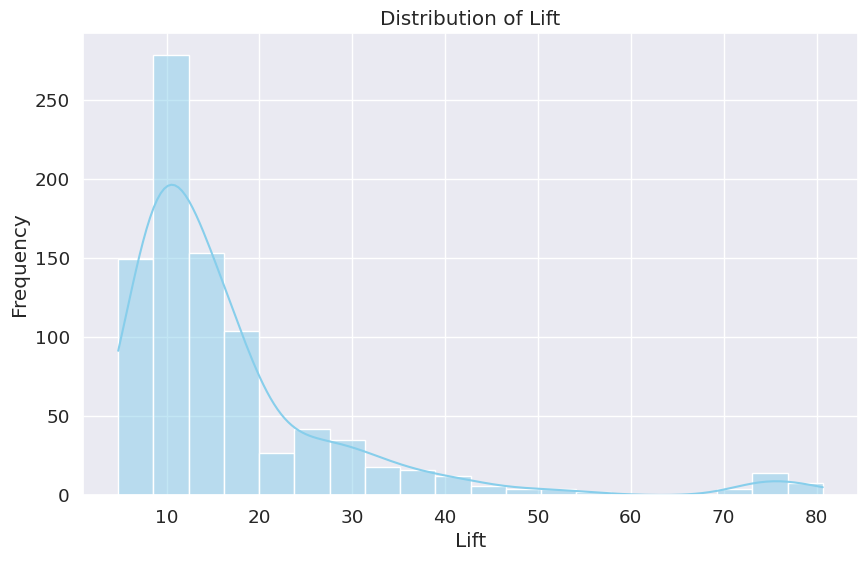

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rules['lift'], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Lift")
plt.xlabel("Lift")
plt.ylabel("Frequency")
plt.show()


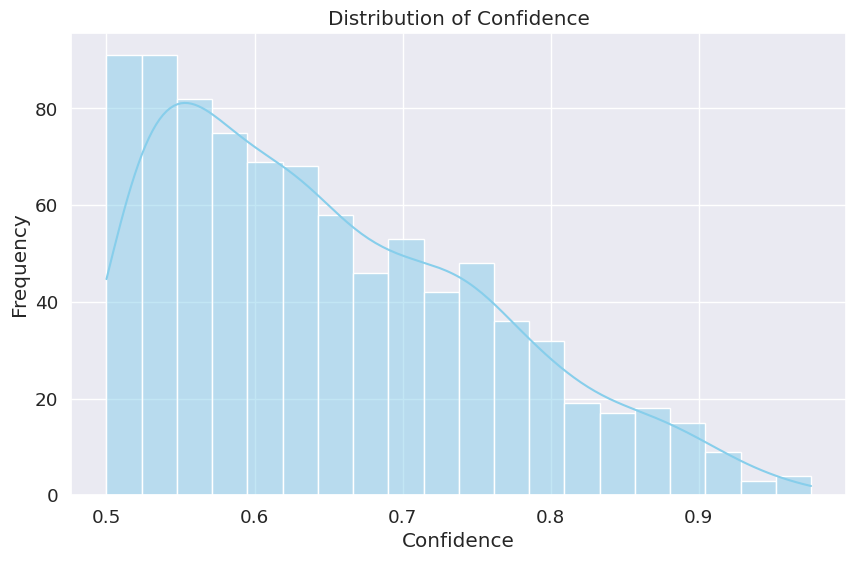

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rules['confidence'], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Confidence")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()


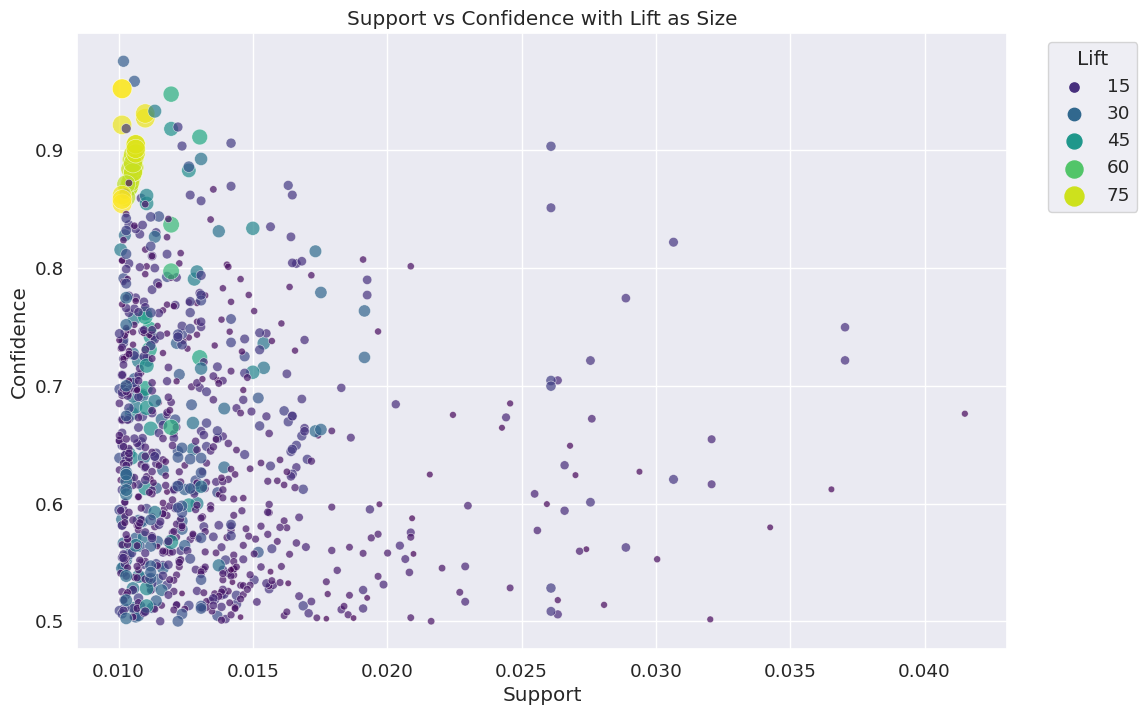

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='support', y='confidence', size='lift', sizes=(20, 200), hue='lift', data=rules, palette="viridis", alpha=0.7)
plt.title("Support vs Confidence with Lift as Size")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(title="Lift", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


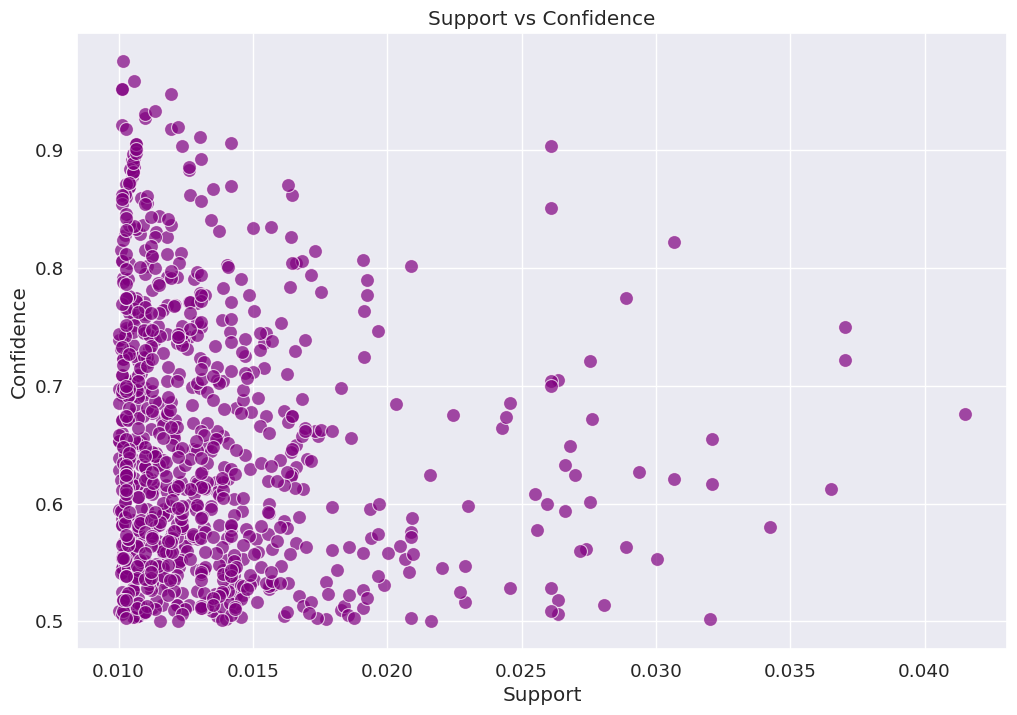

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(x='support', y='confidence', data=rules, color="purple", s=100, alpha=0.7)  # تحديد اللون والحجم بشكل ثابت
plt.title("Support vs Confidence")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()


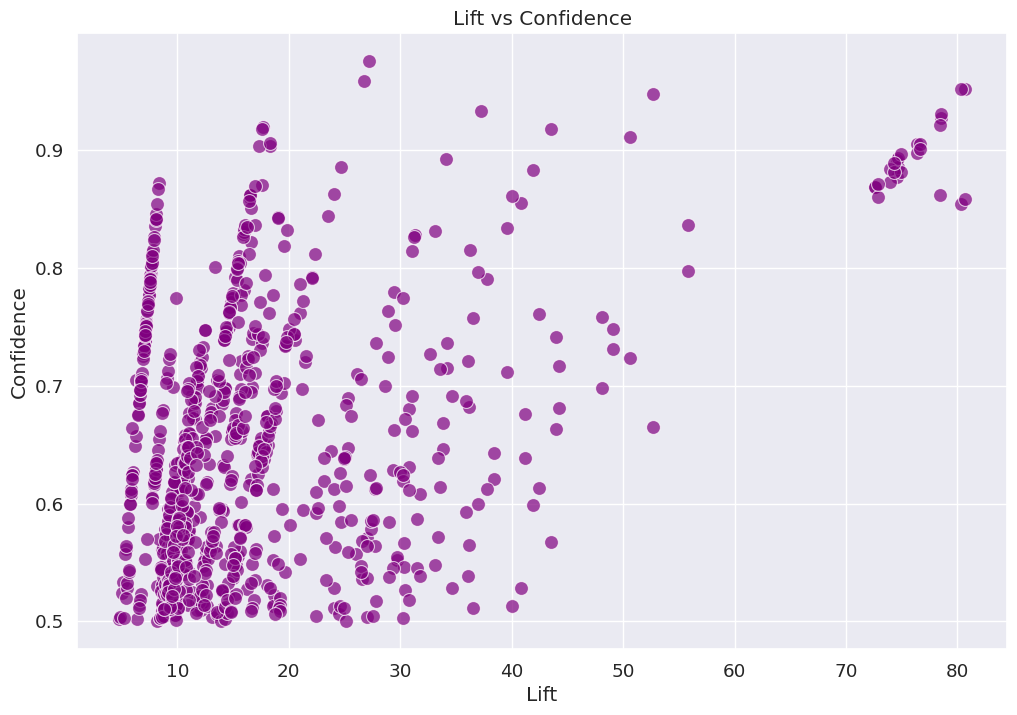

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(x='lift', y='confidence', data=rules, color="purple", s=100, alpha=0.7)  # تحديد لون وحجم ثابت للنقاط
plt.title("Lift vs Confidence")
plt.xlabel("Lift")
plt.ylabel("Confidence")
plt.show()
